<a href="https://colab.research.google.com/github/cosmina98/PhD/blob/main/2022/Oct/Random_Walk_kernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install grakel --quiet

     |████████████████████████████████| 1.6 MB 6.4 MB/s 
     |████████████████████████████████| 154 kB 59.9 MB/s 


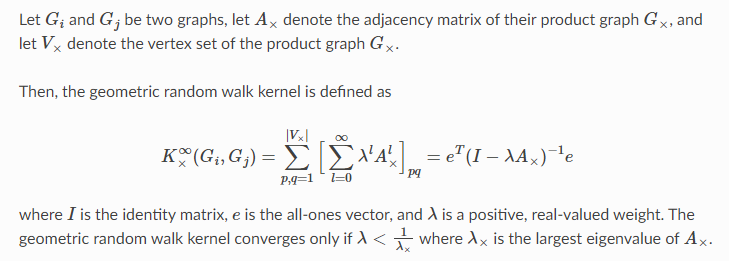

# Using Grakel library

In [9]:
from grakel import GraphKernel
from grakel import Graph
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from grakel import RandomWalk,RandomWalkLabeled
import numpy as np
import networkx as nx


## Kernel between 2  molecules graphs 

In [4]:
H2O_adjacency = [[0, 1, 1], [1, 0, 0], [1, 0, 0]]
H2O_node_labels = {0: 'O', 1: 'H', 2: 'H'}
H2O = Graph(initialization_object=H2O_adjacency, node_labels=H2O_node_labels)
H3O_adjacency = [[0, 1, 1, 1], [1, 0, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0]]
H3O_node_labels = {0: 'O', 1: 'H', 2: 'H', 3:'H'}
H3O = Graph(initialization_object=H3O_adjacency, node_labels=H3O_node_labels)

The shortest path kernel which counts the number of shortest paths of equal length in two graphs 

In [5]:

sp_kernel =  RandomWalkLabeled()
#compute the graph representtaion between water and itself
sp_kernel.fit_transform([H2O])
#compute the kernel value between the graoh representation of water and hydronium
sp_kernel.transform([H3O])

array([[13.59574468]])

## Apply normalisation

In [7]:
sp_kernel = RandomWalkLabeled(normalize=True)
sp_kernel.fit_transform([H2O])
sp_kernel.transform([H3O])

array([[0.99765491]])

#Function to work with NX graph

https://github.com/emanuele/jstsp2015/blob/master/gk_shortest_path.py
https://networkx.org/documentation/networkx-1.9/_modules/networkx/algorithms/shortest_paths/dense.html#floyd_warshall_numpy

In [13]:
def compare(g_1, g_2, verbose=False,nodelist=None):
        """Compute the kernel value (similarity) between two graphs.
        Parameters
        ----------
        g1 : networkx.Graph
            First graph.
        g2 : networkx.Graph
            Second graph.
        Returns
        -------
        k : The similarity value between g1 and g2.
        """
        # Diagonal superior matrix of the floyd warshall shortest
        # paths:
        A = nx.to_numpy_matrix(g_1,nodelist=nodelist, nonedge=np.inf, multigraph_weight=min,weight='weight')
        B= nx.to_numpy_matrix(g_2,nodelist=nodelist,nonedge=np.inf, multigraph_weight=min,weight='weight')
        n,m = A.shape
        p,q=B.shape
        I = np.identity(n)
        A[I==1] = 0 # diagonal elements should be zero
        I2=np.identity(p)
        B[I2==1]=0
        for i in range(n):
            A = np.minimum(A, A[i,:] + A[:,i])
        for i in range(p):
            B = np.minimum(B, B[i,:] + B[:,i])

        fwm1 =np.array(A)
        #replace nan inf with 0
        fwm1 = np.where(fwm1 == np.inf, 0, fwm1)
        fwm1 = np.where(fwm1 == np.nan, 0, fwm1)
        #Upper triangle 
        fwm1 = np.triu(fwm1, k=1)
        #
        bc1 = np.bincount(fwm1.reshape(-1).astype(int))

        fwm2 = np.array(B)
         #replace nan inf with 0
        fwm2 = np.where(fwm2 == np.inf, 0, fwm2)
        fwm2 = np.where(fwm2 == np.nan, 0, fwm2)
        fwm2 = np.triu(fwm2, k=1)
        bc2 = np.bincount(fwm2.reshape(-1).astype(int))

        # Copy into arrays with the same length the non-zero shortests
        # paths:
        v1 = np.zeros(max(len(bc1), len(bc2)) - 1)
        v1[range(0, len(bc1)-1)] = bc1[1:]

        v2 = np.zeros(max(len(bc1), len(bc2)) - 1)
        v2[range(0, len(bc2)-1)] = bc2[1:]

        return np.sum(v1 * v2)


def compare_normalized(g_1, g_2, verbose=False):
        """Compute the normalized kernel value between two graphs.
        A normalized version of the kernel is given by the equation:
        k_norm(g1, g2) = k(g1, g2) / sqrt(k(g1,g1) * k(g2,g2))
        Parameters
        ----------
        g1 : networkx.Graph
            First graph.
        g2 : networkx.Graph
            Second graph.
        Returns
        -------
        k : The similarity value between g1 and g2.
        """
        return compare(g_1, g_2) / (np.sqrt(compare(g_1, g_1) *
                                                 compare(g_2, g_2)))

## Testing to see if we get a similar score using custom implementation 

In [10]:
def get_nxgraph_from_adjanecy_matrix(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    all_rows = range(0, adjacency_matrix.shape[0])
    for n in all_rows:
        gr.add_node(n)
    gr.add_edges_from(edges)
    gr.add_edges_from(edges)
    return gr


In [11]:
G1=get_nxgraph_from_adjanecy_matrix(np.array(H2O_adjacency))
G2=get_nxgraph_from_adjanecy_matrix(np.array(H3O_adjacency))


In [14]:
compare(G1, G2, verbose=False)

9.0

In [15]:
compare_normalized(G1, G2, verbose=False)

0.9486832980505138